# <center> **נושאים מתקדמים בכריית מידע וגילוי ידע - פרוייקט מסכם** </center>
# <center> Airline Marketing campaign: Client database analysis and classification</center>

### <center>Sergei Merson</center>

# <center>Part I - Main Dataset</center>

## <center>1.1 - Data preparation and EDA</center>

On the first step, we need to load our data, analyse its structure and explore it fo any possible anomalies

In [1]:
# Imported libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set default settings
pd.set_option('display.precision', 3)
np.random.seed = 42

In [2]:
# Read the training dataset:
df = pd.read_csv('data/ffp_train.csv', header=0, index_col=0)

# Create lists with categorical, numerical and target variables:
target = ['BUYER_FLAG']
pred_cat = ['BOARD_GROUP',
            'STATUS_PANTINUM', 'STATUS_GOLD', 'STATUS_SILVER',
            'PET_FLAG', 'DENIED_BOARDING', 'SUITCASE_FLAG', 'LOUNGE_FLAG']
pred_num = list(df.columns.drop(pred_cat).drop(target).values)

In [3]:
# Check that there are no NaN values:
print('There {} NaN values in the dataset'.format(np.sum(df.isnull().values)))

There 0 NaN values in the dataset


Class distribution graph:


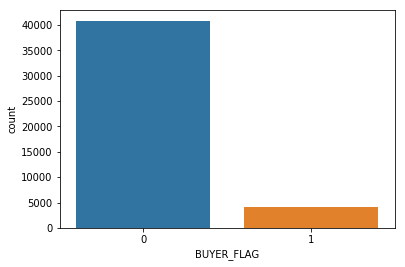

In [4]:
# Plot target distribution:
print('Class distribution graph:')
sns.countplot(x="BUYER_FLAG", data=df)
plt.show()

In [5]:
# Descirbe dataset and get basic statistics:
print('Basic statistics:')
print(df.describe().transpose()[['count', 'mean', 'std', 'min', '50%', 'max']])

Basic statistics:
                    count        mean        std  min     50%        max
BOARD_GROUP       45000.0       3.004  1.412e+00  1.0     3.0  5.000e+00
STATUS_PANTINUM   45000.0       0.009  9.456e-02  0.0     0.0  1.000e+00
STATUS_GOLD       45000.0       0.046  2.101e-01  0.0     0.0  1.000e+00
STATUS_SILVER     45000.0       0.232  4.219e-01  0.0     0.0  1.000e+00
NUM_DEAL          45000.0       4.000  1.996e+00  0.0     4.0  1.600e+01
LAST_DEAL         45000.0     600.341  4.709e+02  0.0   480.0  5.520e+03
ADVANCE_PURCHASE  45000.0      20.676  4.699e+00  6.0    20.0  4.200e+01
FARE_L_Y1         45000.0    1800.592  6.014e+02  0.0  1670.0  6.070e+03
FARE_L_Y2         45000.0    1801.116  6.011e+02  0.0  1670.0  6.450e+03
FARE_L_Y3         45000.0    1800.795  5.996e+02  0.0  1680.0  6.500e+03
FARE_L_Y4         45000.0    1801.343  5.995e+02  0.0  1670.0  6.340e+03
FARE_L_Y5         45000.0    1800.750  6.019e+02  0.0  1680.0  6.630e+03
MILES_L_Y1        45000.0    1796

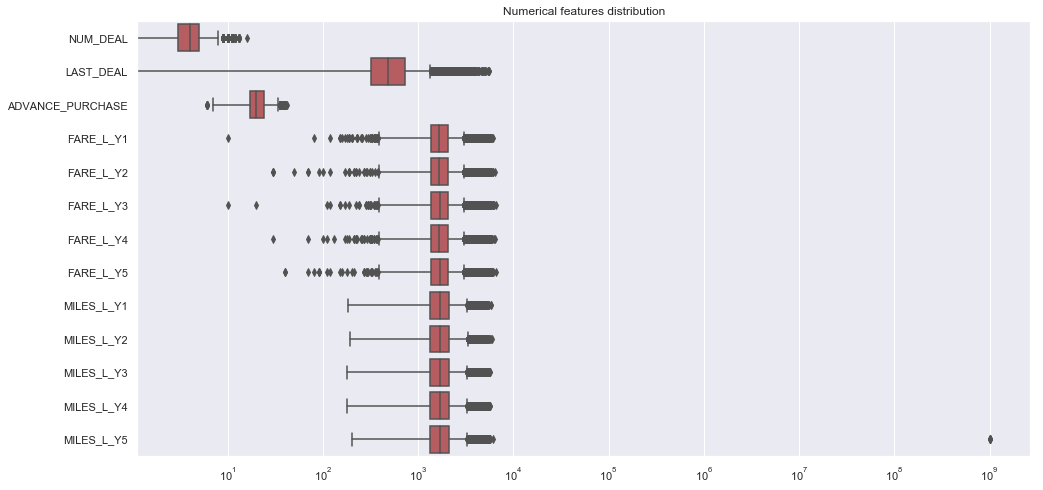

In [6]:
# Plot graphs for numerical features:
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=df[pred_num], orient='h', color='r')
ax.set_title('Numerical features distribution')
ax.set_xscale('log')

Here we can see that ***"MILES_L_Y5"*** feature has unusually high mean and max values, need to investigate for possible outliers

In [8]:
# Find extreme outliers:
print('Records with extreme "MILES_L_Y5" values:\n')
print(df[['MILES_L_Y5', 'BUYER_FLAG']].iloc[np.where(df.MILES_L_Y5.values > 10**5)])

Records with extreme "MILES_L_Y5" values:

       MILES_L_Y5  BUYER_FLAG
ID                           
26074  1000000000           1
26084  1000000000           1
26101  1000000000           1
26122  1000000000           1
26129  1000000000           1


In [9]:
# Remove extreme outliers from the dataset:
df = df.iloc[np.where(df.MILES_L_Y5.values <= 10**5)]

Feature distributions after removing outliers:


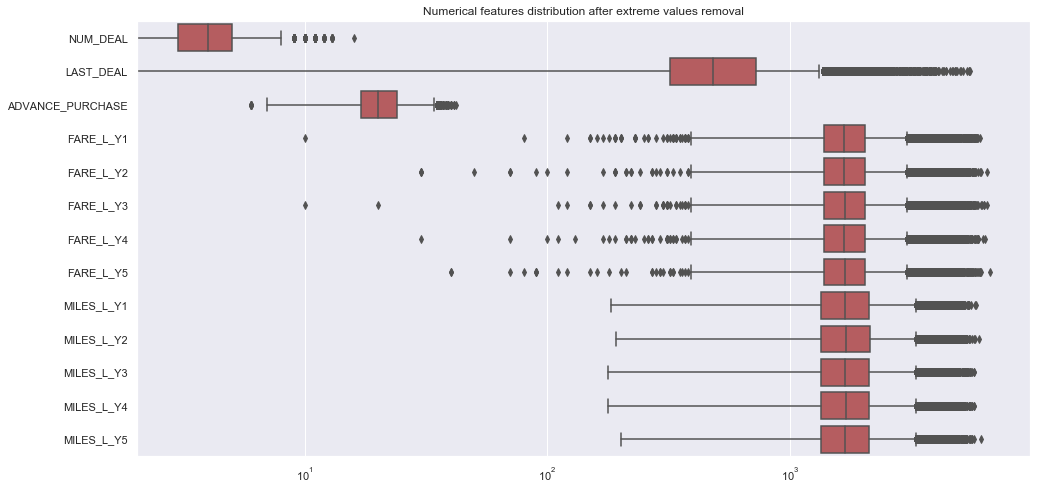

In [10]:
# Once again print distribution graph for numerical features:
print('Feature distributions after removing outliers:')
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=df[pred_num], orient='h', color='r')
ax.set_title('Numerical features distribution after extreme values removal')
ax.set_xscale('log')

Now we can see, that our data looks normal, without extreme outliers, so we can process to the next step

## <center>1.2 - Data transformation</center>

In [12]:
from sklearn.model_selection import train_test_split

# Separate predictors from target variable:
y = df[target].values.ravel().astype('float')
X = df.drop(target, axis=1).values.astype('float')

# Split data into train and validation set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup dict to store datasets:
cont_data = {0: {'name': 'original', 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}}

### Scale features

As we saw earlier, our features are different in their scales: some of them are in the range of thousands, some are binary, some - categorical. Many classifiers are very sensitive for such difference and require preliminar data transformation to the same (+/-) scale. We will try several different scalers to get optimal result.

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from copy import deepcopy
np.random.seed = 42


# Setup dict to store scallers:
cont_scal = {'stnd_scal': StandardScaler(), 'min_max': MinMaxScaler(), 'rbst_scal': RobustScaler()}

# Loop over scalers and transform original data:
for name, scaller in cont_scal.items():
    X_scld_train = deepcopy(cont_data[0]['X_train'])
    X_scld_test  = deepcopy(cont_data[0]['X_test'])
    
    # Apply scaller to numerical features:
    X_scld_train[:,4:17] = scaller.fit_transform(X_scld_train[:,4:17])
    X_scld_test[:,4:17] = scaller.transform(X_scld_test[:,4:17])
    
    # Save results:
    cont_data[len(cont_data)] = {'name': name,
                                 'X_train': X_scld_train, 'y_train': y_train,
                                 'X_test': X_scld_test, 'y_test': y_test}

In [14]:
# Print the content of cont_data:
pd.DataFrame.from_dict(cont_data, orient='index')

,name,X_train,y_train,X_test,y_test
0,original,"[[1.0, 0.0, 0.0, 0.0, 4.0, 480.0, 21.0, 1900.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 3.0, 1400.0, 16.0, 3750....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,stnd_scal,"[[1.0, 0.0, 0.0, 0.0, -0.0012345486056544958, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5005470385960511, 1.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,min_max,"[[1.0, 0.0, 0.0, 0.0, 0.25, 0.0869565217391304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 0.1875, 0.25362318840579...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,rbst_scal,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.142857142857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5, 2.3, -0.5714285714...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


### PCA transformation

Many features in our dataset are covariate, it is possible that PCA transformation would help to classifiert to achieve better performance.

In [15]:
from sklearn.decomposition import PCA
np.random.seed = 42

# Apply PCA transformation and save results:
for i in range(len(cont_data)):
    pca = PCA()
    pca_name = cont_data[i]['name'] + '_pca'
    pca_X_train = pca.fit_transform(cont_data[i]['X_train'])
    pca_X_test = pca.transform(cont_data[i]['X_test'])
    
    # Save results:
    cont_data[len(cont_data)] = {'name': pca_name,
                                 'X_train': pca_X_train, 'y_train': y_train,
                                 'X_test': pca_X_test, 'y_test': y_test}

In [16]:
# Print the content of cont_data:
pd.DataFrame.from_dict(cont_data, orient='index')

,name,X_train,y_train,X_test,y_test
0,original,"[[1.0, 0.0, 0.0, 0.0, 4.0, 480.0, 21.0, 1900.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 3.0, 1400.0, 16.0, 3750....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,stnd_scal,"[[1.0, 0.0, 0.0, 0.0, -0.0012345486056544958, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5005470385960511, 1.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,min_max,"[[1.0, 0.0, 0.0, 0.0, 0.25, 0.0869565217391304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 0.1875, 0.25362318840579...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,rbst_scal,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.142857142857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5, 2.3, -0.5714285714...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,original_pca,"[[-122.06839994897787, -27.08097620199411, -90...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[3795.0048311825794, 2470.8057057725387, -102...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
5,stnd_scal_pca,"[[-0.1963342306808966, 2.005637544925566, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[6.339022008518918, 0.9964077308805093, 0.986...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,min_max_pca,"[[2.009277441791421, -0.2486176016995348, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[1.0099438619111736, 0.7229823251115692, -0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
7,rbst_scal_pca,"[[-0.20655683084963944, 1.9996612042225441, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[6.049691020864288, 1.021256902202262, 0.8602...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


### Upsampling

As we saw earlier, our dataset is skewed, meaning that there is only about 9% of ***Class 1*** observations, and that could interfere classifiers to make meaningful predictions. So we would upscale the dataset to ballance classes. There are many algorithms to do so, we will test four of them: *Random Oversampler*, *SMOTE*, *SMOTEenn*, and *SMOTEtomek*.

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
np.random.seed = 42

# Setup dict to store upsamplers:
cont_upsm = {'rndm': RandomOverSampler(random_state=42),
             'smote': SMOTE(random_state=42),
             'smote_enn': SMOTEENN(random_state=42),
             'smote_tmk': SMOTETomek(random_state=42)}

s = len(cont_data)

for upsm_name, upsampler in cont_upsm.items():
    for i in range(s):
        name = cont_data[i]['name'] + '_' + upsm_name
        X_upsm_test, y_upsm_test = cont_data[i]['X_test'], cont_data[i]['y_test']
        X_upsm_train, y_upsm_train = upsampler.fit_resample(cont_data[i]['X_train'], cont_data[i]['y_train'])
        
            # Save results:
        cont_data[len(cont_data)] = {'name': name,
                                     'X_train': X_upsm_train, 'y_train': y_upsm_train,
                                     'X_test': X_upsm_test, 'y_test': y_upsm_test}

In [18]:
# Print the content of cont_data:
pd.DataFrame.from_dict(cont_data, orient='index')

,name,X_train,y_train,X_test,y_test
0,original,"[[1.0, 0.0, 0.0, 0.0, 4.0, 480.0, 21.0, 1900.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 3.0, 1400.0, 16.0, 3750....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,stnd_scal,"[[1.0, 0.0, 0.0, 0.0, -0.0012345486056544958, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5005470385960511, 1.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,min_max,"[[1.0, 0.0, 0.0, 0.0, 0.25, 0.0869565217391304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 0.1875, 0.25362318840579...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,rbst_scal,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.142857142857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5, 2.3, -0.5714285714...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,original_pca,"[[-122.06839994897787, -27.08097620199411, -90...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[3795.0048311825794, 2470.8057057725387, -102...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
5,stnd_scal_pca,"[[-0.1963342306808966, 2.005637544925566, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[6.339022008518918, 0.9964077308805093, 0.986...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,min_max_pca,"[[2.009277441791421, -0.2486176016995348, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[1.0099438619111736, 0.7229823251115692, -0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
7,rbst_scal_pca,"[[-0.20655683084963944, 1.9996612042225441, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[6.049691020864288, 1.021256902202262, 0.8602...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
8,original_rndm,"[[1.0, 0.0, 0.0, 0.0, 4.0, 480.0, 21.0, 1900.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, 3.0, 1400.0, 16.0, 3750....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
9,stnd_scal_rndm,"[[1.0, 0.0, 0.0, 0.0, -0.0012345486056544958, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[2.0, 0.0, 0.0, 1.0, -0.5005470385960511, 1.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


Now, when we get 40 different versions of the dataset, it would be wise to save it in pickle file for futher use.

In [19]:
import pickle

# Save the dict with datasets:
with open('data/40_ffp_versions.pkl', 'wb') as pickle_out:
    pickle.dump(cont_data, pickle_out)

## <center>1.3 - Testing 'out-of-the-box' model performance</center>

Sklearn library comes with many powerfull models, so we will try several of them and check their performanse (with default settings)

In [20]:
# In case you want to start from this section, just change 0 to 1 tl load the dict with datasets:
if True == 0:
    
    # Import libraries:
    import pickle
    
    with open('data/40_types_of_tr_data.pkl', 'rb') as pickle_in:
        cont_data = pickle.load(pickle_in)

In [21]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
np.random.seed = 42

Most models by default use accuracy as their target metric, but actually we are not interested in maximisation of some synthetic metric, but to maximise profit. In our case we also have different 'cost' of TP and FP answers: TP worths 170 (meaning, that we predicted that customer would buy our product **and** he actualy did), when FP worth -40 (we spent money to send our proposal **but** customer didn't use it). So, to help the classifiers to achieve maximum performance, we will create our oun score metric that calculate profit per 1000 customers.

In [22]:
# Import libraries:
from sklearn.metrics import make_scorer

# Define function that evaluate profit (per 1000 clients) of marketing campaign:
def eval_profit(y_true, y_pred):
    FP_val=-40
    TP_val=170
    outcome = np.sum(np.array(y_pred)) * FP_val
    income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
    return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


# Create scorer based on this function:
my_score = make_scorer(eval_profit, greater_is_better=True)

Now we need to create function that would take classifier, train and test data, and then run GridSearchCV model with selected model. We chose GridSearcCV to avoid overfitting problem as possible. Than we calculate scoring metrics for cross-validation on training set and also for test set.

In [23]:
# Import libraries:
from time import time
from copy import deepcopy
from datetime import timedelta, datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import (precision_score as precision,
                             recall_score as recall,
                             f1_score as f1,
                             roc_auc_score as auc,
                             accuracy_score as accuracy,
                             classification_report)


# Define function to evaluate model performance:
def eval_performance(model, X_train, y_train, X_test, y_test):
    np.random.seed = 42
    
    # Define scoring metrics:
    scoring = {'accuracy':  make_scorer(accuracy),
               'precision': make_scorer(precision),
               'recall':    make_scorer(recall),
               'f1':        make_scorer(f1),
               'auc':       make_scorer(auc),
               'profit':    my_score}
    
    # Record start time:
    t_0 = time()
    
    # Setup GridSearchCV instance:
    gs = GridSearchCV(estimator=model,
                      scoring=scoring,
                      refit='profit',
                      param_grid={},
                      return_train_score=False,
                      cv=5,
                      iid=False)

    # print debug message:
    print('{}\tTraining model...'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S')))

    # Fit the model and extract train cv results:    
    gs.fit(X_train, y_train)
    
    # Save cv train results:
    ind = gs.best_index_
    train_cv_res = {'accuracy (trn)':  gs.cv_results_['mean_test_accuracy'][ind].item(),
                    'precision (trn)': gs.cv_results_['mean_test_precision'][ind].item(),
                    'recall (trn)':    gs.cv_results_['mean_test_recall'][ind].item(),
                    'f1 (trn)':        gs.cv_results_['mean_test_f1'][ind].item(),
                    'auc (trn)':       gs.cv_results_['mean_test_auc'][ind].item(),
                    'profit (trn)':    gs.cv_results_['mean_test_profit'][ind].item()}

    # print debug message:
    print('{}\tMaking predictions...'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S')))
    
    # Make predictions:
    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)[:,1]

    # Calculate metrics:
    test_cv_res = {'accuracy (tst)':  accuracy(y_test, y_pred),
                   'precision (tst)': precision(y_test, y_pred),
                   'recall (tst)':    recall(y_test, y_pred),
                   'f1 (tst)':        f1(y_test, y_pred),
                   'auc (tst)':       auc(y_test, y_prob),
                   'profit (tst)':    eval_profit(y_test, y_pred)}
    
    dur = timedelta(seconds=(time() - t_0))
    
    # print debug message:
    print('{0}\tFinished, time spent: {1}'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), dur))
    
    return {'model': deepcopy(gs), 'duration': dur, **train_cv_res, **test_cv_res}

Now we are ready to test selected classifiers. We will save the results in the pickle file, because it takes more than 10 hours to run these models on laptop :(

In [ ]:
# Import libraries:
import warnings
from time import time
from copy import deepcopy
from datetime import timedelta, datetime

# Initiate classifier dict:
cont_models = {'lgr': LogisticRegression(solver='liblinear'),
               'knn': KNeighborsClassifier(),
               'dtc': DecisionTreeClassifier(),
               'rnf': RandomForestClassifier(n_estimators=100),
               'xgb': XGBClassifier(nthread=-1)}

# Setup list to store results:
rez = []

# test all  the models on all the datasets:
for cl_name, cl_model in cont_models.items():
    
    # print debug message:
    print('\n', '='*80, sep='')
    print('\n{1}\tModel: {0}'.format(cl_name, datetime.now().strftime('%Y.%m.%d, %H:%M:%S')))
    set_n = 1

    for data in cont_data.values():
        # print debug message:
        print('\n', '-'*70, sep='')
        print('\n{1}\tDataset #{2}: {0}'.format(data['name'], datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), set_n))
                
        # Temporary ignore warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Evaluate model:
            cl_perf = eval_performance(model=deepcopy(cl_model),
                                       X_train=data['X_train'],
                                       y_train=data['y_train'],
                                       X_test=data['X_test'],
                                       y_test=data['y_test'])
        
        # Save results:
        rez.append({'classifier': cl_name, 'dataset': data['name'], **cl_perf})
        set_n += 1

print('All jobs are done!')

In [ ]:
# Import libraries:
import pickle

# Save the dict with datasets:
with open('models/ffp_OutOfTheBox.pkl', 'wb') as pickle_out:
    pickle.dump(rez, pickle_out)

In [27]:
# Convert result dict into dataframe:
df_rez = pd.DataFrame(rez, columns=['classifier', 'dataset', 'model', 'duration',
                                    'profit (trn)', 'profit (tst)',
                                    'accuracy (trn)', 'accuracy (tst)',
                                    'precision (trn)', 'precision (tst)',
                                    'recall (trn)', 'recall (tst)',
                                    'f1 (trn)', 'f1 (tst)',
                                    'auc (trn)', 'auc (tst)'])

# Find best result for each model:
ind_best = []
for m in cont_models:
    ind_best.append(df_rez[df_rez['classifier'] == m]['profit (tst)'].idxmax())
df_rez.iloc[ind_best].sort_values('profit (tst)', ascending=False)

,classifier,dataset,model,duration,profit (trn),profit (tst),accuracy (trn),accuracy (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst)
184,xgb,original_smote_enn,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:39.834698,92755.706,2495.833,0.912,0.852,0.978,0.282,0.879,0.403,0.917,0.332,0.923,0.671
144,rnf,original_smote_enn,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:04:11.198512,99962.636,2428.048,0.954,0.851,0.978,0.279,0.948,0.402,0.960,0.329,0.956,0.667
42,knn,min_max,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:05:26.946840,587.561,672.297,0.898,0.901,0.316,0.327,0.076,0.084,0.122,0.134,0.529,0.591
0,lgr,original,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:33.806936,0.000,0.000,0.906,0.909,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.608
91,dtc,rbst_scal_rndm,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:19.857633,82842.476,-386.710,0.946,0.847,0.903,0.171,1.000,0.176,0.949,0.173,0.946,0.545


As we can see, RandomForest and XGBM models show best performance on original dataset, upsampled with SMOTEENN algorithm. We will continue with these two models, so we need to save them and the dataset used into pickle file.

In [30]:
# Extract optimal dataset:
ffp_opt_ds = cont_data[24] # Original dataset upsampled with SMOTEenn is stored in cont_data dict with index 24

# Save optimal datasets into pickle file:
with open('data/ffp_opt_ds', 'wb') as pickle_out:
    pickle.dump(ffp_opt_ds, pickle_out)

# Reassign train and test varialbes to optimal dataset:
X_train, y_train, X_test, y_test = ffp_opt_ds['X_train'], ffp_opt_ds['y_train'], ffp_opt_ds['X_test'], ffp_opt_ds['y_test']

## <center>1.4 - Parameter tuning</center>

As the result of previous steps, we get two models that showed us pretty good performance

In [31]:
# To load the dict with model and datasets, change 0 to 1:
if True == 0:

    # Import libraries:
    import pickle
    from sklearn.metrics import make_scorer

    
    # Define function that evaluate profit (per 1000 clients) of marketing campaign:
    def eval_profit(y_true, y_pred):
        FP_val=-40
        TP_val=170
        outcome = np.sum(np.array(y_pred)) * FP_val
        income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
        return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


    # Create scorer based on this function:
    my_score = make_scorer(eval_profit, greater_is_better=True)

    with open('data/ffp_opt_ds', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']

To check several parameters, we created formula, that gets train and test datasets, classifier, and dict with descriprion what we want to check on each step (we can't just run GridSearchCV with **all** the parameters, it would take us too much time)

In [ ]:
# Import libraries:
import os
import pickle
import numpy as np
from time import time
from copy import deepcopy
from datetime import timedelta, datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import (precision_score as precision,
                             recall_score as recall,
                             f1_score as f1,
                             roc_auc_score as auc,
                             accuracy_score as accuracy,
                             classification_report)


# Function for parameter tuning:


def parameter_tester(X_train, y_train, X_test, y_test, model, p_tuning_settings,
                     save=True, path='models/', model_name=''):
    
    # Set random seed:
    np.random.seed = 42
    
    # Initialize dict with parameters to pass:
    p_dict = dict()

    # Setup list to store iterations history:
    hist_list = []

    # Define scoring metrics:
    scoring = {'accuracy':  make_scorer(accuracy),
               'precision': make_scorer(precision),
               'recall':    make_scorer(recall),
               'f1':        make_scorer(f1),
               'auc':       make_scorer(auc),
               'profit':    my_score}
    
    # Setup GridSearchCV instance:
    gs = GridSearchCV(estimator=model,
                      scoring=scoring,
                      refit='profit',
                      param_grid={},
                      return_train_score=False,
                      cv=5,
                      iid=False)

    # Record start time:
    t_start = time()
    
    for step in sorted(p_tuning_settings.keys()):

        # print debug message:
        print('-'*115)
        print('{0}\tStarting Step {1}...'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), step))

        # Record step start time:
        t_step_start = time()

        # Add parameters from settings dictionary to p_dict.
        # Please note, if there are same parameters in both dictionaries,
        # than parameters from the settings dict overwrite such in p_dict:
        p_dict = {**p_dict, **p_tuning_settings[step]}

        # print debug message:
        print('\t\t\tPassing parameters to model: {}'.format(p_dict))

        # Pass new parameters to the model:
        gs.set_params(**{'param_grid': p_dict})

        # print debug message:
        print('\t\t\tTraining model...')

        # Train the model:
        gs.fit(X_train, y_train)

        # print debug message:
        print('\t\t\tModel was trained successfully!')
        print('\t\t\tBest parameters: {}'.format(gs.best_params_))

        # Save cv train results:
        ind = gs.best_index_
        train_cv_res = {'accuracy (trn)':  gs.cv_results_['mean_test_accuracy'][ind].item(),
                        'precision (trn)': gs.cv_results_['mean_test_precision'][ind].item(),
                        'recall (trn)':    gs.cv_results_['mean_test_recall'][ind].item(),
                        'f1 (trn)':        gs.cv_results_['mean_test_f1'][ind].item(),
                        'auc (trn)':       gs.cv_results_['mean_test_auc'][ind].item(),
                        'profit (trn)':    gs.cv_results_['mean_test_profit'][ind].item()}
        
        # print debug message:
        print('{}\tMaking predictions...'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S')))
        
        # Make predictions:
        y_pred = gs.predict(X_test)
        y_prob = gs.predict_proba(X_test)[:,1]

        # Calculate metrics:
        test_cv_res = {'accuracy (tst)':  accuracy(y_test, y_pred),
                       'precision (tst)': precision(y_test, y_pred),
                       'recall (tst)':    recall(y_test, y_pred),
                       'f1 (tst)':        f1(y_test, y_pred),
                       'auc (tst)':       auc(y_test, y_prob),
                       'profit (tst)':    eval_profit(y_test, y_pred)}
 
        # Record step duration:
        t_step_dur = timedelta(seconds=(time() - t_step_start))
        
        # Append step_record to hist_dict:
        hist_list.append({'step': step, 'model': deepcopy(gs), 'tested parameters': p_tuning_settings[step],
                          'optimal parameters': gs.best_params_, 'duration': t_step_dur,
                          **train_cv_res, **test_cv_res})

        # Update parameters in p_dict with optimal values:
        for p in p_tuning_settings[step]:
            p_dict[p] = [gs.best_params_[p]]

        # print debug message:
        print('{0}\tStep {1} finished successfully!\tStep duration: {2}'.format(
            datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), step, t_step_dur))

    # Record overall duration:
    t_dur = timedelta(seconds=(time() - t_start))

    print('{0}\tAll done!\tOverall time: {1}'.format(datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), t_dur))

    if save:
        # Create path directory if it doesn't exist:
        if not os.path.isdir(path):
            os.makedirs(path)

        # Create default name for model:
        if model_name == '':
            model_name = 'GridSearchCV - ' + str(gs.estimator)[:str(gs.estimator).find('(')]
        time_stamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        file_path = path + time_stamp + ' - ' + model_name + '.pkl'

        # Save the dictionary into file
        with open(file_path, 'wb') as pickle_out:
            pickle.dump(hist_list, pickle_out)

        print('The results were saved in {}'.format(file_path))

    return hist_list

### XGBM

In [ ]:
# Import libraries:
import warnings
from xgboost.sklearn import XGBClassifier


# Define parameter settings for each tuning step:
p_set_xgb = {0: {},
             1: {'learning_rate':  [0.1, 0.05, 0.01],
                 'n_estimators':   range(100, 1001, 100)},

             2: {'max_depth':          range(1,11,1),
                 'min_child_weight':   range(1,6,1)},

             3: {'gamma':      [i/10.0 for i in range(0,6)]},

             4: {'subsample':  [i/10.0 for i in range(6,11)],
                 'colsample_bytree':   [i/10.0 for i in range(6,11)]},

             5: {'reg_alpha':          [1e-5, 1e-2, 0.1, 1, 100]},

             6: {'learning_rate':  [0.01, 0.001],
                 'n_estimators':   [100, 500, 1000, 2500, 5000]}}

# Temporary ignore warnings:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Start parameter tuner:
    xgb_p_tuner = parameter_tester(model=XGBClassifier(nthread=-1),
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   p_tuning_settings=p_set_xgb,
                                   save=True,
                                   path='models/')

In [35]:
import pandas as pd

# Pirnt tuning results:
pd.DataFrame(xgb_p_tuner, columns=['step', 'duration', 'tested parameters', 'optimal parameters',
                                   'profit (trn)', 'profit (tst)',
                                   'precision (trn)', 'precision (tst)',
                                   'recall (trn)', 'recall (tst)',
                                   'f1 (trn)', 'f1 (tst)',
                                   'auc (trn)', 'auc (tst)',
                                   'accuracy (trn)', 'accuracy (tst)']).sort_values('profit (tst)', ascending=False)

,step,duration,tested parameters,optimal parameters,profit (trn),profit (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst),accuracy (trn),accuracy (tst)
1,1,01:02:03.275284,"{'learning_rate': [0.1, 0.05, 0.01], 'n_estima...","{'learning_rate': 0.1, 'n_estimators': 1000}",94429.845,2498.055,0.986,0.294,0.894,0.371,0.922,0.328,0.935,0.670,0.925,0.862
0,0,00:00:32.260244,{},{},92755.706,2495.833,0.978,0.282,0.879,0.403,0.917,0.332,0.923,0.671,0.912,0.852
6,6,03:13:50.685868,"{'learning_rate': [0.01, 0.001], 'n_estimators...","{'colsample_bytree': 0.9, 'gamma': 0.0, 'learn...",96725.228,2391.377,0.982,0.284,0.916,0.381,0.940,0.325,0.944,0.667,0.937,0.856
4,4,03:37:28.400255,"{'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'cols...","{'colsample_bytree': 0.9, 'gamma': 0.0, 'learn...",95079.713,2219.135,0.986,0.282,0.900,0.358,0.926,0.315,0.938,0.650,0.929,0.859
5,5,00:43:22.824041,"{'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]}","{'colsample_bytree': 0.9, 'gamma': 0.0, 'learn...",95097.764,2178.020,0.986,0.280,0.900,0.357,0.926,0.314,0.938,0.650,0.929,0.858
2,2,04:56:41.220882,"{'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),...","{'learning_rate': 0.1, 'max_depth': 10, 'min_c...",95018.765,2135.793,0.986,0.277,0.899,0.359,0.926,0.312,0.938,0.659,0.928,0.856
3,3,01:02:11.243299,"{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}","{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",95018.765,2135.793,0.986,0.277,0.899,0.359,0.926,0.312,0.938,0.659,0.928,0.856


In [36]:
# Extract best model:
xgb_ffp = xgb_p_tuner[1]['model']

# Save best model into pickle file:
with open('models/ffp_xgb_best.pkl', 'wb') as pickle_out:
    pickle.dump(xgb_ffp, pickle_out)

### Random Forest

In [ ]:
# Import libraries:
import warnings
from sklearn.ensemble import RandomForestClassifier
np.random.state = 42

# Define parameter settings for each tuning step:
p_set_rfc = {0: {},
             
             1: {'criterion':          ['gini', 'entropy'],
                 'class_weight':       [None, 'balanced']},
             
             2: {'max_depth':          [None] + [i*5 for i in range(1,11)],
                 'max_leaf_nodes':     [None] + [i*10 for i in range(1,11)]},
             
             3: {'min_samples_split':   range(2,11,2)},

             4: {'n_estimators':       range(100, 2001, 100)}}

             
# Temporary ignore warnings:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Start parameter tuner:
    rfc_p_tuner = parameter_tester(model=RandomForestClassifier(n_estimators=100),
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   p_tuning_settings=p_set_rfc,
                                   save=True,
                                   path='models/',
                                   model_name='rnf_rff_final_tuned_model')

In [40]:
import pandas as pd

# Pirnt tuning results:
pd.DataFrame(rfc_p_tuner, columns=['step', 'duration', 'tested parameters', 'optimal parameters',
                                   'profit (trn)', 'profit (tst)',
                                   'precision (trn)', 'precision (tst)',
                                   'recall (trn)', 'recall (tst)',
                                   'f1 (trn)', 'f1 (tst)',
                                   'auc (trn)', 'auc (tst)',
                                   'accuracy (trn)', 'accuracy (tst)']).sort_values('profit (tst)', ascending=False)

,step,duration,tested parameters,optimal parameters,profit (trn),profit (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst),accuracy (trn),accuracy (tst)
4,4,12:35:18.498580,"{'n_estimators': (100, 200, 300, 400, 500, 600...","{'class_weight': 'balanced', 'criterion': 'gin...",100520.485,2674.742,0.977,0.284,0.953,0.424,0.963,0.340,0.958,0.661,0.957,0.851
3,3,00:17:56.074239,"{'min_samples_split': (2, 4, 6, 8, 10)}","{'class_weight': 'balanced', 'criterion': 'gin...",100228.939,2623.625,0.976,0.283,0.951,0.421,0.961,0.338,0.956,0.661,0.955,0.850
1,1,00:19:17.784874,"{'criterion': ['gini', 'entropy'], 'class_weig...","{'class_weight': 'balanced', 'criterion': 'gini'}",100361.511,2558.062,0.977,0.280,0.952,0.418,0.962,0.335,0.957,0.663,0.956,0.849
2,2,04:15:29.469222,"{'max_depth': [None, 5, 10, 15, 20, 25, 30, 35...","{'class_weight': 'balanced', 'criterion': 'gin...",100432.549,2526.947,0.977,0.279,0.952,0.418,0.962,0.334,0.957,0.666,0.956,0.849
0,0,00:04:32.855976,{},{},100004.946,2412.490,0.978,0.279,0.948,0.399,0.960,0.328,0.956,0.661,0.954,0.851


In [41]:
# Extract best model:
rfc_ffp = rfc_p_tuner[4]['model']

# Save best model into pickle file:
with open('models/ffp_rfc_best.pkl', 'wb') as pickle_out:
    pickle.dump(rfc_ffp, pickle_out)

### Result evaluation

Now we have two tuned models, so we can asses their performance on test set

In [ ]:
# To load the dict with model and datasets, change 0 to 1:
if True == 0:

    # Import libraries:
    import pickle
    from sklearn.metrics import make_scorer

    
    # Define function that evaluate profit (per 1000 clients) of marketing campaign:
    def eval_profit(y_true, y_pred):
        FP_val=-40
        TP_val=170
        outcome = np.sum(np.array(y_pred)) * FP_val
        income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
        return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


    # Create scorer based on this function:
    my_score = make_scorer(eval_profit, greater_is_better=True)

    # Load optimal dataset:
    with open('data/ffp_opt_ds', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']
    
    # Load XGBM tuned model:
    with open('models/ffp_xgb_best.pkl', 'rb') as pickle_in:
        xgb_ffp = pickle.load(pickle_in)
    
    # Load RandomForest tuned model:
    with open('models/ffp_rfc_best.pkl', 'rb') as pickle_in:
        rfc_ffp = pickle.load(pickle_in)

In [42]:
# Predict results for the test dataset:
xgb_ffp_y_pred = xgb_ffp.predict(X_test)
rfc_ffp_y_pred = rfc_ffp.predict(X_test)

In [47]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix, XGBM:')
print(confusion_matrix(y_test, xgb_ffp_y_pred))

# Print confusion matrix for both datasets:
print('\nConfusion matrix, RandomForest:')
print(confusion_matrix(y_test, rfc_ffp_y_pred))

Confusion matrix, XGBM:
[[7450  730]
 [ 515  304]]

Confusion matrix, RandomForest:
[[7307  873]
 [ 472  347]]


XGBM seems to be more cautious when in deside to assign Class 1 to an observation then RandomForest, it seams that default threshold cut off many observations that could be otherwise marked as Class 1, we need to investigate.

In [49]:
# Calculate profit per 1000 customers for each threshold value:

thresholds = [i/100 for i in range(101)]
xgb_ffp_y_prob = xgb_ffp.predict_proba(X_test)[:,1]
rfc_ffp_y_prob = rfc_ffp.predict_proba(X_test)[:,1]

# Setup lists to store results:
xgb_rez_lst = []
rfc_rez_lst = []

for thr in thresholds:
    xgb_rez_lst.append(eval_profit(y_test, np.where(xgb_ffp_y_prob >= thr, 1, 0)))   
    rfc_rez_lst.append(eval_profit(y_test, np.where(rfc_ffp_y_prob >= thr, 1, 0)))

In [50]:
# Save results into dataframe and melt it:
perfomance_df = pd.DataFrame({'threshold':    thresholds,
                              'XGBM':         xgb_rez_lst,
                              'RandomForest': rfc_rez_lst})

perfomance_df = pd.melt(frame=perfomance_df, id_vars='threshold', value_vars=['XGBM', 'RandomForest'],
                        var_name='model', value_name='result')

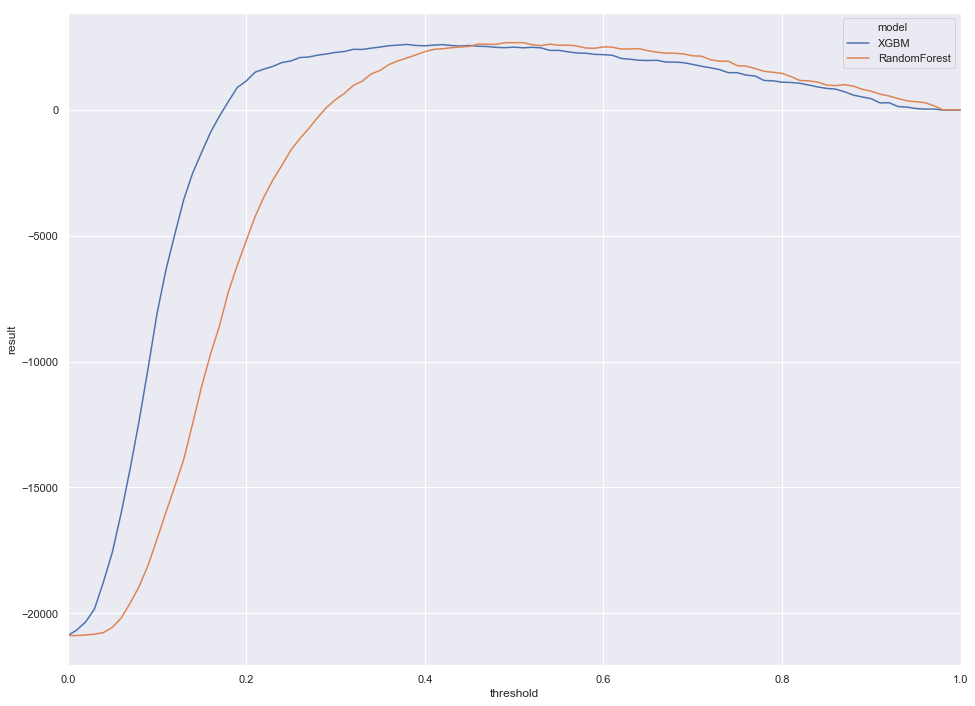

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot graph for both models:
fig, ax = plt.subplots(nrows=1, figsize=(16,12))
sns.lineplot(data=perfomance_df, x='threshold', y='result', hue='model', ax=ax)
ax.set(xlim=(0,1))
ax.legend()
plt.show()

In [66]:
# Print the best possible result for both models and result when threshold = 0.5:
print('XGBM:\t\tBest result/threashold:', str(round(np.max(xgb_rez_lst),2)), '-', str(thresholds[np.argmax(xgb_rez_lst)]),
      '\t\tDefault result:', str(round(xgb_rez_lst[51], 2)))
print('RandomForest:\tBest result/threashold:', str(round(np.max(rfc_rez_lst),2)), '-',
      str(thresholds[np.argmax(rfc_rez_lst)]), '\t\tDefault result:', str(round(rfc_rez_lst[51], 2)))

XGBM:		Best result/threashold: 2606.96 - 0.38 		Default result: 2471.39
RandomForest:	Best result/threashold: 2678.08 - 0.49 		Default result: 2676.96


So, as we can see, RandomForest classifier not only outperforms XGBM, but also has optimal threshold around 0.5

# <center>Part II - Reviews Dataset</center>

## <center>2.1 - Data preparation and EDA</center>

// To save the time, we've already united reviews and ffp dataset into single file

In [76]:
# Import libraries:
import numpy as np
import pandas as pd


# Read CSV with train set into pandas dataframe:
df = pd.read_csv('data/ffpAndReviews_training.csv', index_col=0, header=0)

Class distribution graph:


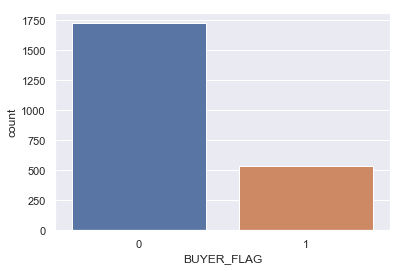

In [77]:
# Import libriaries:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target distribution:
print('Class distribution graph:')
sns.countplot(x="BUYER_FLAG", data=df)
plt.show()

As in previous task, this dataset also skewed, we will need to take care of that in the later steps

## <center>2.2 - Data transformation</center>

In [78]:
# Import libraries:
from sklearn.model_selection import train_test_split


# Extract features and target variables:
X = df.drop(columns='BUYER_FLAG').values.astype('float')
y = df['BUYER_FLAG'].values.astype('float')

# Split data into train and validation set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF*IDF transformation

In [79]:
# Define the formula that transforms original data set into TF*IDF representation:


def apply_tf_idf(vals):
    # number of documents
    n_lines = vals.shape[0]
    # TF - weight of the word in the document
    if(np.sum(vals, axis=1)[:,None].any == 0):
        print(np.sum(vals, axis=1)[:,None])
    tf = np.divide(vals, np.sum(vals, axis=1)[:,None])
    # IDF - adjusted weight of the word in the whole set of documents
    idf = np.log(n_lines / np.count_nonzero(vals, axis=0))
    # return numpy array with converted values
    return np.nan_to_num(tf * idf)


# Apply TF*IDF transformation on features arrays:
X_tf_idf = apply_tf_idf(X)

# Split data into train and validation set:
X_train_tf_idf, X_test_tf_idf, _, _ = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)

In [80]:
# Save dataframes into dict:
cont_data = {0: {'name': 'original', 'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
             1: {'name': 'tf_idf', 'X_train': X_train_tf_idf, 'y_train': y_train,
                 'X_test': X_test_tf_idf, 'y_test': y_test}}

### Scale features

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from copy import deepcopy
np.random.seed = 42

# Setup dict to store scallers:
cont_scal = {'stnd_scal': StandardScaler(),
             'min_max':   MinMaxScaler(),
             'rbst_scal': RobustScaler()}

for i in range(len(cont_data)):
    for sc_name, scaller in cont_scal.items():
        name = cont_data[i]['name'] + sc_name
        X_scld_train = deepcopy(cont_data[i]['X_train'])
        X_scld_test  = deepcopy(cont_data[i]['X_test'])

        # Apply scaller (on columns from ffp dataset that were appended to review dataset):
        X_scld_train[:,1342:1355] = scaller.fit_transform(X_scld_train[:,1342:1355])
        X_scld_test[:,1342:1355] = scaller.transform(X_scld_test[:,1342:1355])

        # Save results:
        cont_data[len(cont_data)] = {'name': name,
                                     'X_train': X_scld_train, 'y_train': y_train,
                                     'X_test': X_scld_test, 'y_test': y_test}

### Upsampling

In [82]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
np.random.seed = 42

# Setup dict to store upsamplers:
cont_upsm = {'rndm': RandomOverSampler(random_state=42),
             'smote': SMOTE(random_state=42),
             'smote_enn': SMOTEENN(random_state=42),
             'smote_tmk': SMOTETomek(random_state=42)}

s = len(cont_data)

for upsm_name, upsampler in cont_upsm.items():
    for i in range(s):
        name = cont_data[i]['name'] + '_' + upsm_name
        X_upsm_test, y_upsm_test = cont_data[i]['X_test'], cont_data[i]['y_test']
        X_upsm_train, y_upsm_train = upsampler.fit_resample(cont_data[i]['X_train'], cont_data[i]['y_train'])
        
            # Save results:
        cont_data[len(cont_data)] = {'name': name,
                                     'X_train': X_upsm_train, 'y_train': y_upsm_train,
                                     'X_test': X_upsm_test, 'y_test': y_upsm_test}

In [83]:
# Print the content of cont_data:
pd.DataFrame.from_dict(cont_data, orient='index')

,name,X_train,y_train,X_test,y_test
0,original,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,tf_idf,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,originalstnd_scal,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,originalmin_max,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,originalrbst_scal,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,tf_idfstnd_scal,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,tf_idfmin_max,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,tf_idfrbst_scal,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,original_rndm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,tf_idf_rndm,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [84]:
import pickle

# Save the dict with datasets:
with open('data/40_sent_versions.pkl', 'wb') as pickle_out:
    pickle.dump(cont_data, pickle_out)

## <center>2.3 - Testing 'out-of-the-box' model performance</center>

We will apply the same models that we used in the previous step, so we won't import all the libraries and formulas once again

In [85]:
# In case you want to start from this section, just change 0 to 1 tl load the dict with datasets:
if True == 0:
    
    # Import libraries:
    import pickle
    
    with open('data/40_sent_versions.pkl', 'rb') as pickle_in:
        cont_data = pickle.load(pickle_in)

In [ ]:
# Import libraries:
import warnings
from time import time
from datetime import timedelta, datetime

# Initiate classifier dict:
cont_models = {'lgr': LogisticRegression(solver='liblinear'),
               'knn': KNeighborsClassifier(),
               'dtc': DecisionTreeClassifier(),
               'rnf': RandomForestClassifier(n_estimators=100),
               'xgb': XGBClassifier(nthread=-1)}

# Setup list to store results:
rez = []

# test all  the models on all the datasets:
for cl_name, cl_model in cont_models.items():
    
    # print debug message:
    print('\n', '='*80, sep='')
    print('\n{1}\tModel: {0}'.format(cl_name, datetime.now().strftime('%Y.%m.%d, %H:%M:%S')))
    set_n = 1

    for data in cont_data.values():
        # print debug message:
        print('\n', '-'*70, sep='')
        print('\n{1}\tDataset #{2}: {0}'.format(data['name'], datetime.now().strftime('%Y.%m.%d, %H:%M:%S'), set_n))
                
        # Temporary ignore warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # Evaluate model:
            cl_perf = eval_performance(model=cl_model,
                                       X_train=data['X_train'],
                                       y_train=data['y_train'],
                                       X_test=data['X_test'],
                                       y_test=data['y_test'])
        
        # Save results:
        rez.append({'classifier': cl_name, 'dataset': data['name'], **cl_perf})
        set_n += 1

print('All jobs are done!')

In [87]:
# Import libraries:
import pickle

# Save the dict with datasets:
with open('models/sent_OutOfTheBox.pkl', 'wb') as pickle_out:
    pickle.dump(rez, pickle_out)

In [88]:
# Convert result dict into dataframe:
df_rez = pd.DataFrame(rez, columns=['classifier', 'dataset', 'model', 'duration',
                                    'profit (trn)', 'profit (tst)',
                                    'accuracy (trn)', 'accuracy (tst)',
                                    'precision (trn)', 'precision (tst)',
                                    'recall (trn)', 'recall (tst)',
                                    'f1 (trn)', 'f1 (tst)',
                                    'auc (trn)', 'auc (tst)'])

# Find best result for each model:
ind_best = []
for m in cont_models:
    ind_best.append(df_rez[df_rez['classifier'] == m]['profit (tst)'].idxmax())
df_rez.iloc[ind_best].sort_values('profit (tst)', ascending=False)

,classifier,dataset,model,duration,profit (trn),profit (tst),accuracy (trn),accuracy (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst)
168,xgb,original_rndm,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:58.492108,73850.843,21946.903,0.873,0.812,0.849,0.554,0.907,0.727,0.877,0.629,0.873,0.872
147,rnf,originalmin_max_smote_enn,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:17.933143,111673.637,21681.416,0.928,0.834,0.961,0.607,0.938,0.687,0.945,0.645,0.920,0.880
92,dtc,originalrbst_scal_rndm,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:18.679603,78980.066,15951.327,0.893,0.770,0.840,0.479,0.973,0.576,0.901,0.523,0.893,0.700
61,knn,tf_idfstnd_scal_smote,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:04:23.237428,64901.473,9358.407,0.611,0.418,0.568,0.252,0.930,0.838,0.705,0.387,0.611,0.588
9,lgr,tf_idf_rndm,"GridSearchCV(cv=5, error_score='raise-deprecat...",00:00:00.868028,39506.476,9203.540,0.644,0.695,0.693,0.346,0.519,0.444,0.593,0.389,0.644,0.676


Once again, RandomForest and XGBM outperformed other classifiers, so we will continue with these two models.

In [104]:
# Extract optimal dataset:
sent_xgb_opt_ds = cont_data[8] # Original dataset upsampled with RandomSampler is stored in cont_data dict with index 8
sent_rfc_opt_ds = cont_data[27] # Original dataset upsampled with RandomSampler is stored in cont_data dict with index 27

# Save optimal datasets into pickle file:
with open('data/sent_xgb_opt_ds.pkl', 'wb') as pickle_out:
    pickle.dump(sent_xgb_opt_ds, pickle_out)
with open('data/sent_rfc_opt_ds.pkl', 'wb') as pickle_out:
    pickle.dump(sent_rfc_opt_ds, pickle_out)

# Reassign train and test varialbes to optimal for XGBM dataset:
X_train_xgb, y_train_xgb = sent_xgb_opt_ds['X_train'], sent_xgb_opt_ds['y_train']
X_test, y_test = sent_xgb_opt_ds['X_test'], sent_xgb_opt_ds['y_test']

# Reassign train and test varialbes to optimal for RandomForest dataset
# (here we also need to assign X_test, because of min_max transformation that was applies on original data):
X_train_rfc, y_train_rfc = sent_rfc_opt_ds['X_train'], sent_rfc_opt_ds['y_train']
X_test_rfc = sent_rfc_opt_ds['X_test']

## <center>2.4 - Parameter tuning</center>

In [86]:
# To load the dict with model and datasets, change 0 to 1:
if True == 0:

    # Import libraries:
    import pickle
    from sklearn.metrics import make_scorer

    
    # Define function that evaluate profit (per 1000 clients) of marketing campaign:
    def eval_profit(y_true, y_pred):
        FP_val=-40
        TP_val=170
        outcome = np.sum(np.array(y_pred)) * FP_val
        income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
        return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


    # Create scorer based on this function:
    my_score = make_scorer(eval_profit, greater_is_better=True)
    
    # Load optimal for XGBM dataset and assign variables:
    with open('data/sent_xgb_opt_ds.pkl', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train_xgb, y_train_xgb = data['X_train'], data['y_train']
        X_test, y_test = data['X_test'], data['y_test']

    # Load optimal for RandomForest dataset and assign variables:
    with open('data/sent_rfc_opt_ds.pkl', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train_rfc, y_train_rfc = data['X_train'], data['y_train']
        X_test_rfc = data['X_test']

### XGBM

In [ ]:
# Import libraries:
import warnings
from xgboost.sklearn import XGBClassifier


# Define parameter settings for each tuning step:
p_set_xgb = {0: {},
             1: {'learning_rate':      [0.1, 0.05, 0.01],
                 'n_estimators':       range(100, 1001, 100)},

             2: {'max_depth':          range(1,11,1),
                 'min_child_weight':   range(1,6,1)},

             3: {'gamma':              [i/10.0 for i in range(0,6)]},

             4: {'subsample':          [i/10.0 for i in range(6,11)],
                 'colsample_bytree':   [i/10.0 for i in range(6,11)]},

             5: {'reg_alpha':          [1e-5, 1e-2, 0.1, 1, 100]},

             6: {'learning_rate':      [0.001],
                 'n_estimators':       [100, 500, 1000, 5000, 10000]}}

# Temporary ignore warnings:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Start parameter tuner:
    xgb_p_tuner = parameter_tester(model=XGBClassifier(nthread=-1),
                                   X_train=X_train_xgb,
                                   y_train=y_train_xgb,
                                   X_test=X_test,
                                   y_test=y_test,
                                   p_tuning_settings=p_set_xgb,
                                   save=True,
                                   path='models/')

In [93]:
import pandas as pd

# Pirnt tuning results:
pd.DataFrame(xgb_p_tuner, columns=['step', 'duration', 'tested parameters', 'optimal parameters',
                                   'profit (trn)', 'profit (tst)',
                                   'precision (trn)', 'precision (tst)',
                                   'recall (trn)', 'recall (tst)',
                                   'f1 (trn)', 'f1 (tst)',
                                   'auc (trn)', 'auc (tst)',
                                   'accuracy (trn)', 'accuracy (tst)']).sort_values('profit (tst)', ascending=False)

,step,duration,tested parameters,optimal parameters,profit (trn),profit (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst),accuracy (trn),accuracy (tst)
1,1,02:00:12.104019,"{'learning_rate': [0.1, 0.05, 0.01], 'n_estima...","{'learning_rate': 0.1, 'n_estimators': 1000}",82090.776,23473.451,0.930,0.711,0.983,0.697,0.956,0.704,0.954,0.912,0.954,0.872
2,2,08:04:56.619801,"{'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),...","{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",82090.776,23473.451,0.930,0.711,0.983,0.697,0.956,0.704,0.954,0.912,0.954,0.872
3,3,00:52:35.281594,"{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}","{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",82090.776,23473.451,0.930,0.711,0.983,0.697,0.956,0.704,0.954,0.912,0.954,0.872
4,4,02:47:36.640686,"{'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'cols...","{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",82123.451,23008.850,0.929,0.701,0.984,0.687,0.955,0.694,0.954,0.920,0.954,0.867
6,6,02:10:40.826603,"{'learning_rate': [0.001], 'n_estimators': [10...","{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",73759.827,22234.513,0.848,0.553,0.906,0.737,0.876,0.632,0.872,0.875,0.872,0.812
0,0,00:00:56.557997,{},{},73850.843,21946.903,0.849,0.554,0.907,0.727,0.877,0.629,0.873,0.872,0.873,0.812
5,5,00:41:54.662776,"{'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]}","{'colsample_bytree': 0.6, 'gamma': 0.0, 'learn...",82043.610,21880.531,0.931,0.691,0.983,0.657,0.956,0.674,0.954,0.920,0.954,0.861


In [94]:
# Extract best model:
xgb_sent = xgb_p_tuner[1]['model']

# Save best model into pickle file:
with open('models/sent_xgb_best.pkl', 'wb') as pickle_out:
    pickle.dump(xgb_sent, pickle_out)

### Random Forest

In [ ]:
# Import libraries:
import warnings
from sklearn.ensemble import RandomForestClassifier
np.random.state = 42

# Define parameter settings for each tuning step:
p_set_rfc = {0: {},
             
             1: {'criterion':          ['gini', 'entropy'],
                 'class_weight':       [None, 'balanced']},
             
             2: {'max_depth':          [None] + [i*5 for i in range(1,11)],
                 'max_leaf_nodes':     [None] + [i*10 for i in range(1,11)]},
             
             3: {'min_samples_split':   range(2,11,2)},

             4: {'n_estimators':       range(100, 2001, 100)}}

             
# Temporary ignore warnings:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Start parameter tuner:
    rfc_p_tuner = parameter_tester(model=RandomForestClassifier(n_estimators=100),
                                   X_train=X_train_rfc,
                                   y_train=y_train_rfc,
                                   X_test=X_test_rfc,
                                   y_test=y_test,
                                   p_tuning_settings=p_set_rfc,
                                   save=True,
                                   path='models/',
                                   model_name='')

In [97]:
import pandas as pd

# Pirnt tuning results:
pd.DataFrame(rfc_p_tuner, columns=['step', 'duration', 'tested parameters', 'optimal parameters',
                                   'profit (trn)', 'profit (tst)',
                                   'precision (trn)', 'precision (tst)',
                                   'recall (trn)', 'recall (tst)',
                                   'f1 (trn)', 'f1 (tst)',
                                   'auc (trn)', 'auc (tst)',
                                   'accuracy (trn)', 'accuracy (tst)']).sort_values('profit (tst)', ascending=False)

,step,duration,tested parameters,optimal parameters,profit (trn),profit (tst),precision (trn),precision (tst),recall (trn),recall (tst),f1 (trn),f1 (tst),auc (trn),auc (tst),accuracy (trn),accuracy (tst)
3,3,00:01:13.359386,"{'min_samples_split': (2, 4, 6, 8, 10)}","{'class_weight': 'balanced', 'criterion': 'ent...",112159.299,22433.628,0.947,0.614,0.945,0.707,0.942,0.657,0.906,0.871,0.922,0.838
4,4,00:49:12.912969,"{'n_estimators': (100, 200, 300, 400, 500, 600...","{'class_weight': 'balanced', 'criterion': 'ent...",113443.541,22123.894,0.951,0.636,0.955,0.687,0.950,0.660,0.916,0.876,0.932,0.845
1,1,00:01:00.021964,"{'criterion': ['gini', 'entropy'], 'class_weig...","{'class_weight': 'balanced', 'criterion': 'ent...",112010.925,21106.195,0.949,0.611,0.944,0.667,0.942,0.638,0.908,0.867,0.923,0.834
2,2,00:25:07.440028,"{'max_depth': [None, 5, 10, 15, 20, 25, 30, 35...","{'class_weight': 'balanced', 'criterion': 'ent...",112646.152,19911.504,0.947,0.577,0.949,0.646,0.945,0.610,0.909,0.859,0.926,0.819
0,0,00:00:18.436593,{},{},109902.909,19535.398,0.955,0.573,0.924,0.636,0.932,0.603,0.907,0.876,0.914,0.816


In [98]:
# Extract best model:
rfc_sent = rfc_p_tuner[3]['model']

# Save best model into pickle file:
with open('models/sent_rfc_best.pkl', 'wb') as pickle_out:
    pickle.dump(rfc_sent, pickle_out)

### Result evaluation

In [99]:
# To load the dict with model and datasets, change 0 to 1:
if True == 0:

    # Import libraries:
    import pickle
    from sklearn.metrics import make_scorer

    
    # Define function that evaluate profit (per 1000 clients) of marketing campaign:
    def eval_profit(y_true, y_pred):
        FP_val=-40
        TP_val=170
        outcome = np.sum(np.array(y_pred)) * FP_val
        income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
        return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


    # Create scorer based on this function:
    my_score = make_scorer(eval_profit, greater_is_better=True)

    # Load optimal for XGBM dataset and assign variables:
    with open('data/sent_xgb_opt_ds.pkl', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train_xgb, y_train_xgb = data['X_train'], data['y_train']
        X_test, y_test = data['X_test'], data['y_test']

    # Load optimal for RandomForest dataset and assign variables:
    with open('data/sent_rfc_opt_ds.pkl', 'rb') as pickle_in:
        data = pickle.load(pickle_in)
        X_train_rfc, y_train_rfc = data['X_train'], data['y_train']
        X_test_rfc = data['X_test']
    
    # Load XGBM tuned model:
    with open('models/sent_xgb_best.pkl', 'rb') as pickle_in:
        xgb_sent = pickle.load(pickle_in)
    
    # Load RandomForest tuned model:
    with open('models/sent_rfc_best.pkl', 'rb') as pickle_in:
        rfc_sent = pickle.load(pickle_in)

In [100]:
# Predict results for the test dataset:
xgb_sent_y_pred = xgb_sent.predict(X_test)
rfc_sent_y_pred = rfc_sent.predict(X_test_rfc)

In [101]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix, XGBM:')
print(confusion_matrix(y_test, xgb_sent_y_pred))

# Print confusion matrix for both datasets:
print('\nConfusion matrix, RandomForest:')
print(confusion_matrix(y_test, rfc_sent_y_pred))

Confusion matrix, XGBM:
[[325  28]
 [ 30  69]]

Confusion matrix, RandomForest:
[[309  44]
 [ 29  70]]


Now we see that XGBM outperforms RandomForest by more precision predictions on Class 1 alongside with almost equal recall

In [106]:
# Calculate profit per 1000 customers for each threshold value:

thresholds = [i/100 for i in range(101)]
xgb_sent_y_prob = xgb_sent.predict_proba(X_test)[:,1]
rfc_sent_y_prob = rfc_sent.predict_proba(X_test_rfc)[:,1]

# Setup lists to store results:
xgb_rez_lst = []
rfc_rez_lst = []

for thr in thresholds:
    xgb_rez_lst.append(eval_profit(y_test, np.where(xgb_sent_y_prob >= thr, 1, 0)))   
    rfc_rez_lst.append(eval_profit(y_test, np.where(rfc_sent_y_prob >= thr, 1, 0)))

In [107]:
# Save results into dataframe and melt it:
perfomance_df = pd.DataFrame({'threshold':    thresholds,
                              'XGBM':         xgb_rez_lst,
                              'RandomForest': rfc_rez_lst})

perfomance_df = pd.melt(frame=perfomance_df, id_vars='threshold', value_vars=['XGBM', 'RandomForest'],
                        var_name='model', value_name='result')

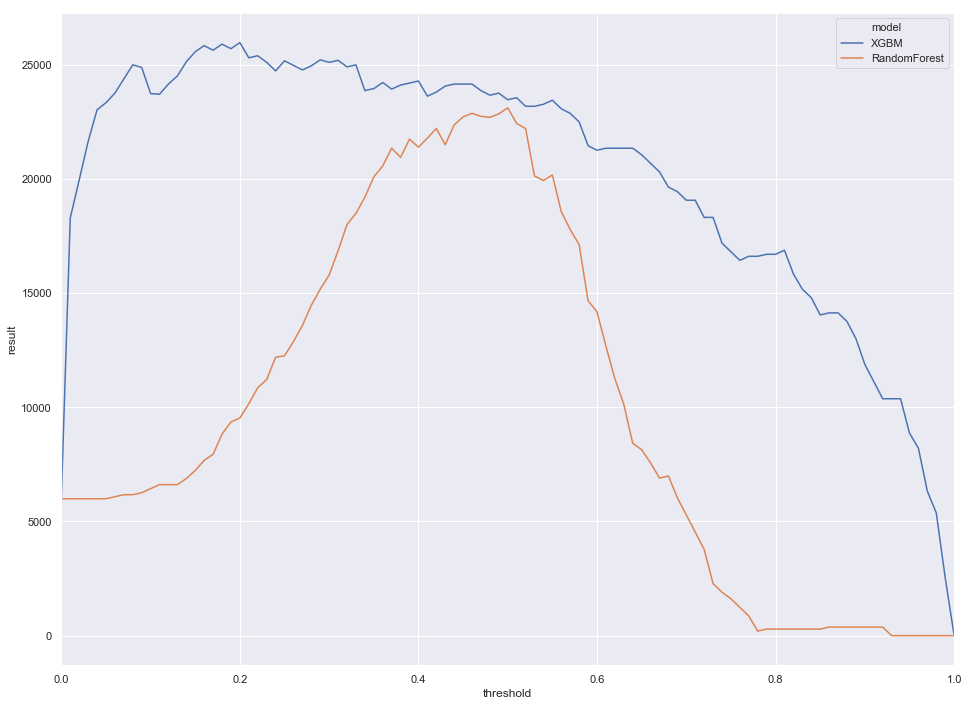

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot graph for both models:
fig, ax = plt.subplots(nrows=1, figsize=(16,12))
sns.lineplot(data=perfomance_df, x='threshold', y='result', hue='model', ax=ax)
ax.set(xlim=(0,1))
ax.legend()
plt.show()

In [109]:
# Print the best possible result for both models and result when threshold = 0.5:
print('XGBM:\t\tBest result/threashold:', str(round(np.max(xgb_rez_lst),2)), '-', str(thresholds[np.argmax(xgb_rez_lst)]),
      '\t\tDefault result:', str(round(xgb_rez_lst[51], 2)))
print('RandomForest:\tBest result/threashold:', str(round(np.max(rfc_rez_lst),2)), '-',
      str(thresholds[np.argmax(rfc_rez_lst)]), '\t\tDefault result:', str(round(rfc_rez_lst[51], 2)))

XGBM:		Best result/threashold: 25973.45 - 0.2 		Default result: 23561.95
RandomForest:	Best result/threashold: 23119.47 - 0.5 		Default result: 22433.63


XGBM outperforms RandomForest model on every threshold.

# <center>Part III - Rollout prediction</center>

In [114]:
# To load the dict with model and datasets, change 0 to 1:
if True == 0:

    # Import libraries:
    import pickle
    from sklearn.metrics import make_scorer

    
    # Define function that evaluate profit (per 1000 clients) of marketing campaign:
    def eval_profit(y_true, y_pred):
        FP_val=-40
        TP_val=170
        outcome = np.sum(np.array(y_pred)) * FP_val
        income = np.sum(np.array(y_true) * np.array(y_pred)) * (TP_val - FP_val)
        return (income + outcome) / float(np.array(y_true).shape[0]) * 1000


    # Create scorer based on this function:
    my_score = make_scorer(eval_profit, greater_is_better=True)

    # Load RandomForest tuned model for ffp dataset:
    with open('models/ffp_rfc_best.pkl', 'rb') as pickle_in:
        rfc_ffp = pickle.load(pickle_in)    

        # Load XGBM tuned model for reviews dataset:
    with open('models/sent_xgb_best.pkl', 'rb') as pickle_in:
        xgb_sent = pickle.load(pickle_in)

In [115]:
# Import libraries:
import pandas as pd

# Read the rollout ffp dataset:
ffp_df = pd.read_csv('data/ffp_rollout_X.csv', header=0, index_col=0)

# Read the rollout reviews dataset:
rev_df = pd.read_csv('data/reviews_rollout.csv', header=0, index_col=0)

# Append predictors from ffp_df to rows in rev_df:
rev_ffp_df = rev_df.join(ffp_df, how='inner')

# Create lists with categorical, numerical and target variables:
target = ['BUYER_FLAG']

In [116]:
# Create recommendations df to store results:
rec_df = pd.DataFrame(index=ffp_df.index, columns=['probability', 'BUYER_FLAG'])

# Print dataframe head:
rec_df.head()

,probability,BUYER_FLAG
ID,,
45001,NaN,NaN
45002,NaN,NaN
45003,NaN,NaN
45004,NaN,NaN
45005,NaN,NaN


In [117]:
# Predict probabilities with both models:
rec_df['probability'] = rfc_ffp.predict_proba(ffp_df.drop(target, axis=1))[:,1]
rec_df.loc[rev_ffp_df.index, 'probability'] = xgb_sent.predict_proba(rev_ffp_df.drop(target, axis=1).values)[:,1]

In [118]:
# Print dataframe head:
rec_df.sort_values('probability', ascending=False).head()

,probability,BUYER_FLAG
ID,,
55180,1.000,NaN
52536,0.999,NaN
55231,0.999,NaN
45033,0.998,NaN
52221,0.998,NaN


In [119]:
# Check how many positive predictions there would be:
print('Number of observations predicted as Class 1:', str(np.sum(np.where(rec_df['probability'] >= 0.5, 1, 0))))

Number of observations predicted as Class 1: 2097


As we can see, there are less than 3,500 (maximum) observations that we predict as Class 1

In [121]:
# Make final assignments:
rec_df[target] = np.where(rec_df['probability'] >= 0.5, 1, 0)

# Print dataframe head:
rec_df.head()

,probability,BUYER_FLAG
ID,,
45001,0.662,1
45002,0.261,0
45003,0.200,0
45004,0.510,1
45005,0.147,0


In [122]:
# Export results:
rec_df.to_csv(path_or_buf='results/recommendations.csv', columns=['BUYER_FLAG'], index=True, header=True)

### <center>The end. It was a very, very interesting exercise!</center>